# Post-Experiment Survey

In [36]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import plot_likert
import scikit_posthocs as ph

import scipy.stats as stats
import seaborn as sns

%env OUTDATED_IGNORE=1
%run ./Plots.ipynb

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

env: OUTDATED_IGNORE=1


# 1. Read Data

In [37]:
# Read raw data
df = pd.read_excel("PostExperiment.xlsx")

# Drop unused columns
df.drop(df.filter(regex='Start time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Completion time').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Email').columns, axis=1, inplace=True)
df.drop(df.filter(regex='Name').columns, axis=1, inplace=True)

# Rename columns
df.columns = ["Row", "Participant", "RankFavourite", "LeastFavourite", "MostFavourite", "RankEase", "LeastEasy", "MostEasy"]

df = df[df["Participant"] > 4]

n_p = len(df.Participant.unique())
conditions = ["AirTouch", "Dwell", "Pinch", "PinchAnywhere"]

print("Read data from {} participants".format(n_p,))


Read data from 15 participants


# 2. Preference Ranks

In [38]:
# Split ranks into their own columns
p = 0
ranks = pd.DataFrame(columns=["Participant", "Technique", "Rank"])
#print(ranks)
ranks_airtouch = []
ranks_dwell = []
ranks_pinch = []
ranks_pinchany = []
ranks_list = []

for row in df.RankFavourite:
    p += 1
    
    order = row.split(";")[0:4]
    
    if p == 1:
        order.reverse()
    
    # Place ranks into the `ranks` data frame
    airtouch = pd.Series([p, "AirTouch", order.index("Touch In The Air") + 1], index=ranks.columns)
    dwell    = pd.Series([p, "Dwell", order.index("Dwell") + 1], index=ranks.columns)
    pinch    = pd.Series([p, "Pinch", order.index("Pinch on Circle") + 1], index=ranks.columns)
    pinchany = pd.Series([p, "PinchAnywhere", order.index("Pinch Anywhere") + 1], index=ranks.columns)
   # print(ranks)
    #print(airtouch)
    #print(dwell)
    
    # ranks = pd.concat([airtouch], ignore_index=True)
    # ranks = pd.concat([dwell], ignore_index=True)
    # ranks = pd.concat([pinch], ignore_index=True)
    # ranks = pd.concat([pinchany], ignore_index=True)
    
    #ranks = pd.concat([airtouch, dwell, pinch, pinchany])
    ranks = pd.concat([airtouch.to_frame().T, dwell.to_frame().T, pinch.to_frame().T, pinchany.to_frame().T], ignore_index=True) # This is the new append however it does not actually append!
    ranks_list.append(ranks) # adds all the ranks to a list before re write 
    #print(ranks)
    
    # Build paired rank lists as well
    ranks_airtouch += [order.index("Touch In The Air") + 1]
    ranks_dwell += [order.index("Dwell") + 1]
    ranks_pinch += [order.index("Pinch on Circle") + 1]
    ranks_pinchany += [order.index("Pinch Anywhere") + 1]
    
ranks = pd.concat(ranks_list) # this is the actual append
rank_counts = ranks.groupby(["Technique", "Rank"]).count().reset_index()

#print(ranks)

rank_counts.replace({"AirTouch": "Air Push", "PinchAnywhere": "Pinch Anywhere"}, inplace=True)

In [39]:
result = stats.friedmanchisquare(ranks_airtouch, ranks_dwell, ranks_pinch, ranks_pinchany)
result_str = friedman_to_LaTeX(result)
print(result_str)
if result[1] < 0.05:
    ph_result = ph.posthoc_nemenyi_friedman(ranks, y_col="Rank", group_col="Technique", block_col="Participant", melted=True )
    ph_result_str = nemenyi_to_LaTeX(ph_result)
    print(ph_result)

$\chi^2 = 14.60, p = 0.002$
               AirTouch     Dwell     Pinch  PinchAnywhere
AirTouch       1.000000  0.255307  0.195566       0.570726
Dwell          0.255307  1.000000  0.900000       0.010066
Pinch          0.195566  0.900000  1.000000       0.006287
PinchAnywhere  0.570726  0.010066  0.006287       1.000000


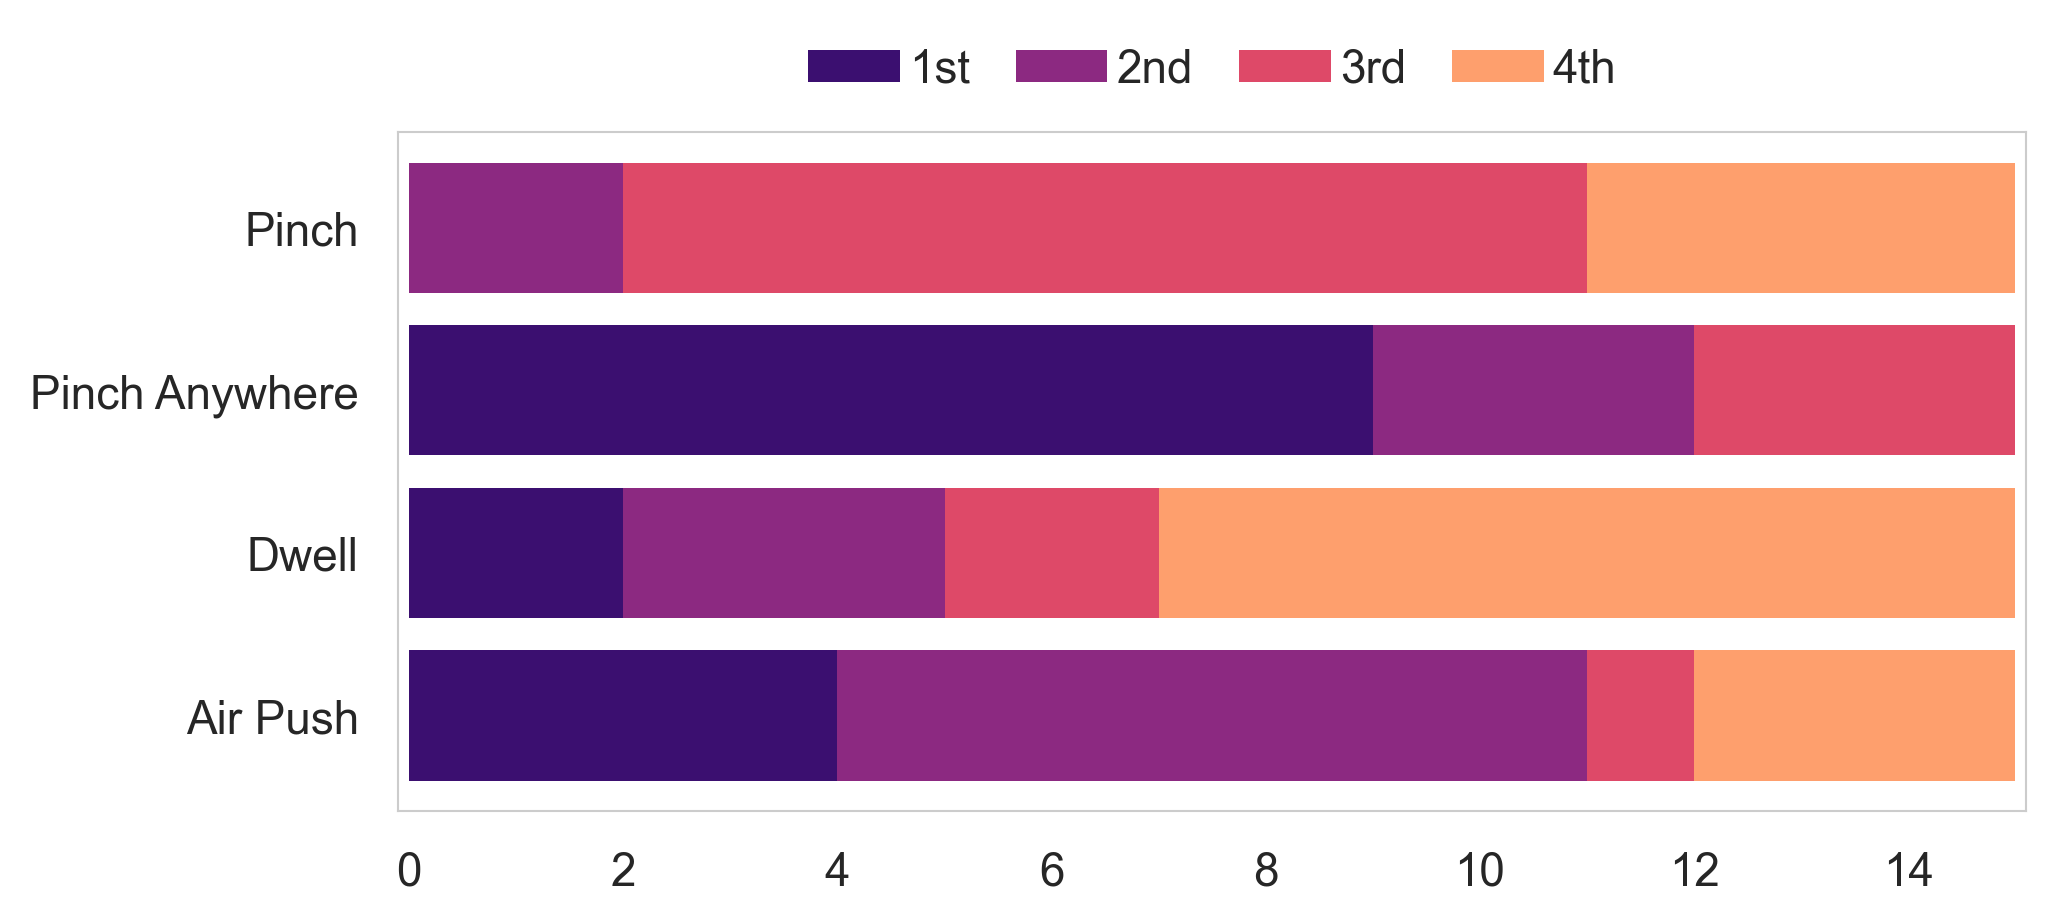

In [40]:
fig, axis = plt.subplots(1, figsize=(7, 3))

offsets = {"Air Push": 0, "Dwell": 0, "Pinch": 0, "Pinch Anywhere": 0}

# For ranks 1 to 4...
for r in range(1, 5):
    rank_data = rank_counts[rank_counts.Rank == r]
    
    # For each technique...
    for t in rank_data.Technique:
        # Count number of responses given
        n = int(rank_data[rank_data.Technique == t].Participant)
        
        # Draw an offset horizontal bar
        plt.barh(t, n, left=offsets[t], color=palette[r - 1])
        
        # Increase the offset for the next bar in the stack
        offsets[t] += n

axis.set_ylabel("")
axis.set_xlabel("")
axis.grid(False)
axis.set(xlim=(-0.1, n_p + 0.1))

plt.legend(["1st", "2nd", "3rd", "4th"], bbox_to_anchor=([0.5, 1, 0, 0]), handletextpad=0.2, columnspacing=1, loc="lower center", ncol=4, frameon=False)

for i in range(1, 4):
    axis.get_legend().legendHandles[i].set_color(palette[i])
    
fig.savefig("Plots/Ranks.pdf", bbox_inches='tight')

# 3. Ease of Use Ranks

In [41]:
# Split ranks into their own columns
p = 0
ranks = pd.DataFrame(columns=["Participant", "Technique", "Rank"])
ranks_airtouch = []
ranks_dwell = []
ranks_pinch = []
ranks_pinchany = []
ranks_list

for row in df.RankEase:
    p += 1
    
    order = row.split(";")[0:4]
    
    if p == 1:
        order.reverse()
    
    # Place ranks into the `ranks` data frame
    airtouch = pd.Series([p, "AirTouch", order.index("Touch In The Air") + 1], index=ranks.columns)
    dwell    = pd.Series([p, "Dwell", order.index("Dwell") + 1], index=ranks.columns)
    pinch    = pd.Series([p, "Pinch", order.index("Pinch on Circle") + 1], index=ranks.columns)
    pinchany = pd.Series([p, "PinchAnywhere", order.index("Pinch Anywhere") + 1], index=ranks.columns)
    
    # ranks = ranks.append(airtouch, ignore_index=True)
    # ranks = ranks.append(dwell, ignore_index=True)
    # ranks = ranks.append(pinch, ignore_index=True)
    # ranks = ranks.append(pinchany, ignore_index=True)
    
    ranks = pd.concat([airtouch.to_frame().T, dwell.to_frame().T, pinch.to_frame().T, pinchany.to_frame().T], ignore_index=True) # This is the new append however it does not actually append!
    ranks_list.append(ranks) # adds all the ranks to a list before re write
    
    # Build paired rank lists as well
    ranks_airtouch += [order.index("Touch In The Air") + 1]
    ranks_dwell += [order.index("Dwell") + 1]
    ranks_pinch += [order.index("Pinch on Circle") + 1]
    ranks_pinchany += [order.index("Pinch Anywhere") + 1]

ranks = pd.concat(ranks_list)
rank_counts = ranks.groupby(["Technique", "Rank"]).count().reset_index()

rank_counts.replace({"AirTouch": "Air Push", "PinchAnywhere": "Pinch Anywhere"}, inplace=True)

In [42]:
stats.friedmanchisquare(ranks_airtouch, ranks_dwell, ranks_pinch, ranks_pinchany)

FriedmanchisquareResult(statistic=7.560000000000002, pvalue=0.056036672389856004)

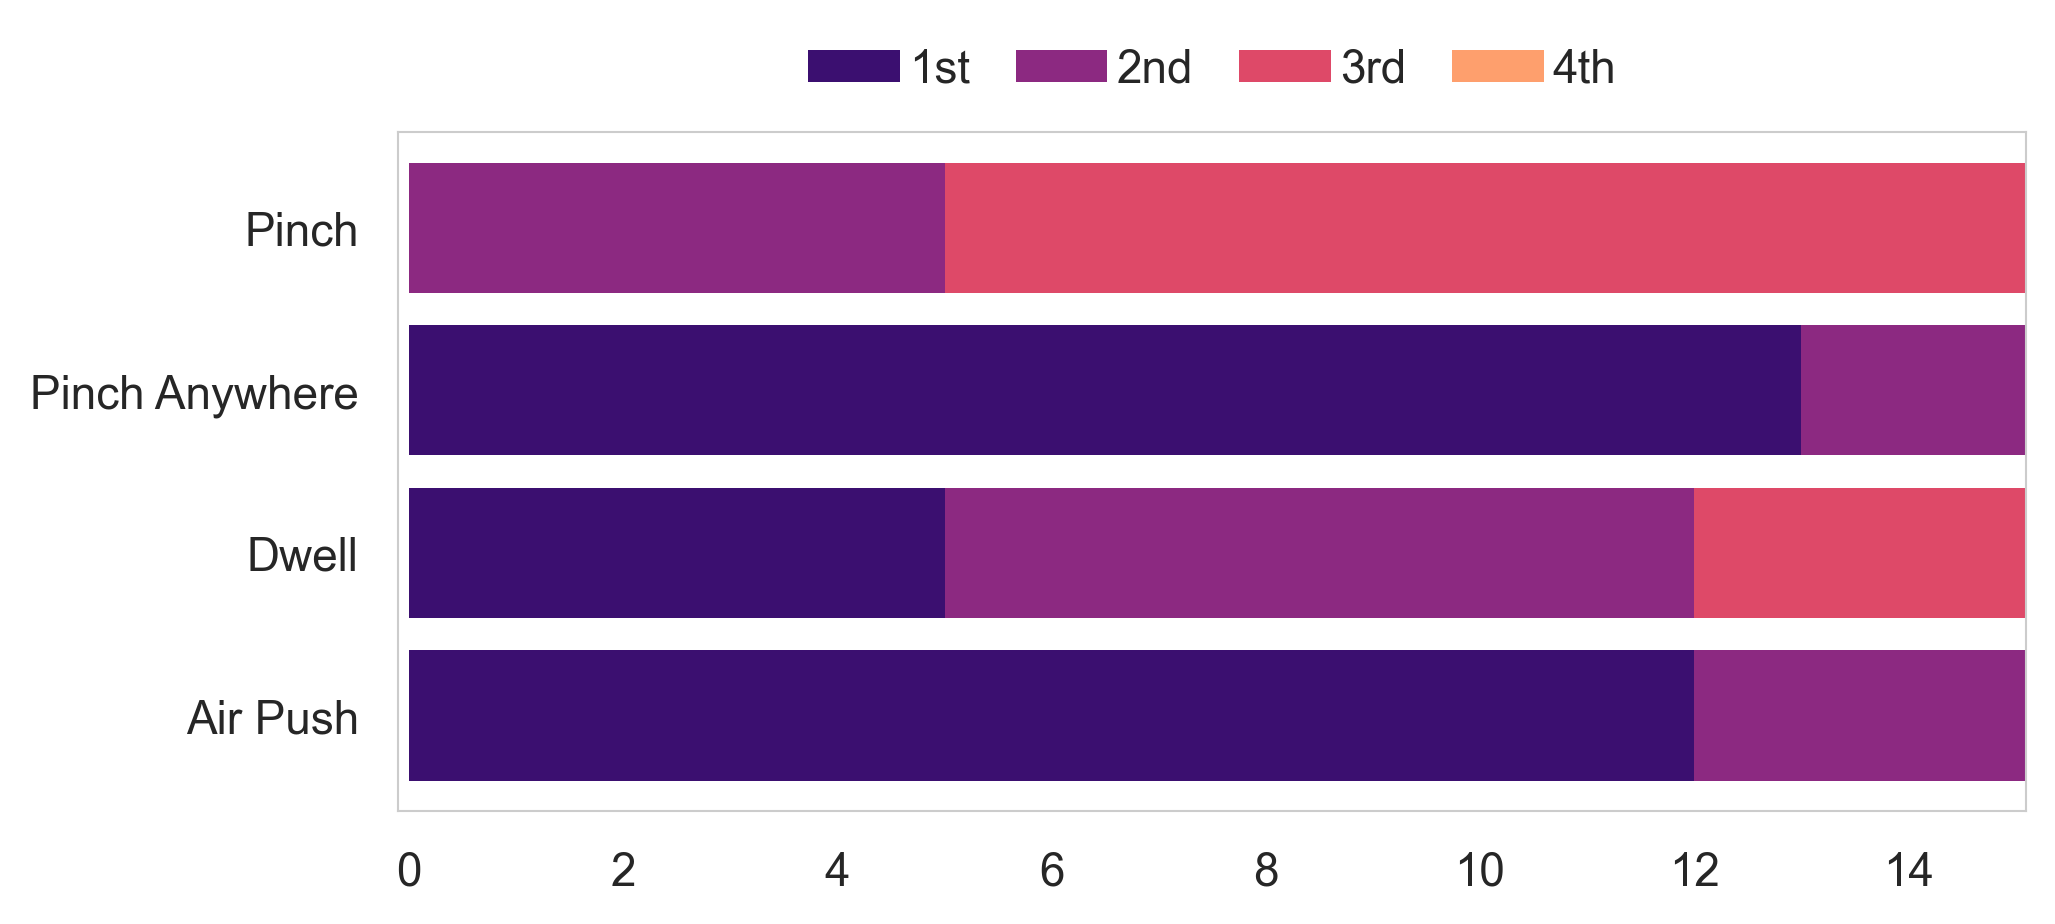

In [43]:
fig, axis = plt.subplots(1, figsize=(7, 3))

offsets = {"Air Push": 0, "Dwell": 0, "Pinch": 0, "Pinch Anywhere": 0}

# For ranks 1 to 4...
for r in range(1, 5):
    rank_data = rank_counts[rank_counts.Rank == r]
    
    # For each technique...
    for t in rank_data.Technique:
        # Count number of responses given
        n = int(rank_data[rank_data.Technique == t].Participant)
        
        # Draw an offset horizontal bar
        plt.barh(t, n, left=offsets[t], color=palette[r - 1])
        
        # Increase the offset for the next bar in the stack
        offsets[t] += n

axis.set_ylabel("")
axis.set_xlabel("")
axis.grid(False)
axis.set(xlim=(-0.1, n_p + 0.1))

plt.legend(["1st", "2nd", "3rd", "4th"], bbox_to_anchor=([0.5, 1, 0, 0]), handletextpad=0.2, columnspacing=1, loc="lower center", ncol=4, frameon=False)

for i in range(1, 4):
    axis.get_legend().legendHandles[i].set_color(palette[i])